In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup, Embedding,Input, Reshape,Flatten

import pandas as pd
df = pd.read_csv('./data/hdb_price_prediction.csv')
df

2022-10-10 20:09:02.933714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 20:09:02.933737: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [2]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [3]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## a) Further split the data from year 2020 and before (i.e. those not in test set) by using data from year 2020 as validation set and the rest as the training set.

In [4]:
from sklearn.preprocessing import LabelEncoder

# function to encode categorical features as numbers as the DNN expects numbers and not strings
def preprocess_df(df):
    category_features = [ 'month', 
                         'flat_model_type', 
                         'storey_range']
    
    numeric_features = ['dist_to_nearest_stn', 
                        'dist_to_dhoby', 
                        'degree_centrality',
                        'eigenvector_centrality', 
                        'remaining_lease_years', 
                        'floor_area_sqm']

    for feature in category_features:
        encoder = LabelEncoder()
        df[feature] = encoder.fit_transform(df[feature])
    return df

In [5]:
df_processed = preprocess_df(df)

In [6]:
# dropping irrelevant data , drop 'year' & 'resale_price' later
df_cleaned = df_processed.drop(['full_address','nearest_stn'],axis=1)

# Split data to train data (<2020 && >2020) and test data (== 2020)
train_dataframe = df_cleaned[df_cleaned.year<2020]
val_dataframe = df_cleaned[df_cleaned.year == 2020]

# drop the remaining year data
train_dataframe = train_dataframe.drop(['year'],axis=1)
val_dataframe = val_dataframe.drop(['year'],axis=1)

## b) For each categorical variable, replace the one-hot encoding with the layer tf.keras.layers.Embedding(). Set output_dim = floor(num_categories//divisor). ‘num_categories’ refers to the number of categories in the categorical variable. ‘divisor’ is a parameter which we will tune later (Hint: You will still need the lookup classes from Q1b. Read the documentation to find out what to change.)

> The Embedding layer produces a 2D output (3D, including batch), which cannot be concatenated with the other features. Add a Flatten layer to resolve this.

In [7]:
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)

2022-10-10 20:09:05.196037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 20:09:05.196532: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 20:09:05.196652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-10 20:09:05.196736: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-10 20:09:05.199134: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

# Building the model
***

### building the input layer:

In [8]:
# function to build input layer
# returns model layer, inputs

def build_input_layer(divisor):
    # building input layer
    numerical_features = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality','eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
    categorical_features = [ 'month', 'flat_model_type', 'storey_range']
    
    # keeping track of each category's cardinality in a dict
    num_categorical_dict = {}

    for feature in categorical_features:
        num_categorical_dict[feature] = df_cleaned[feature].nunique()

    # building an embedding layer for each category column
    inputs = []
    models= []
    
    for cat,categorical_size in num_categorical_dict.items():

        output_dim = categorical_size//divisor
        vocab_size = categorical_size

        # input layer for categorical data only takes 1 row
        inpt = keras.Input(shape=(1,),name=cat)

        # embed layer for categorical data 
        embed = Embedding(vocab_size,
                          output_dim,
                          trainable=True,
                          embeddings_initializer=tf.initializers.random_normal)(inpt)

        # Flatten
        embed_reshaped = Flatten()(embed)
        models.append(embed_reshaped)
        inputs.append(inpt)
        
    # building layers for Numerical features    
    dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
    dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
    degree_centrality =keras.Input(shape=(1,), name="degree_centrality")
    eigenvector_centrality=keras.Input(shape=(1,), name="eigenvector_centrality")
    remaining_lease_years=keras.Input(shape=(1,), name="remaining_lease_years")
    floor_area_sqm =keras.Input(shape=(1,), name="floor_area_sqm")

    # append all numerical inputs
    inputs.append(dist_to_nearest_stn)
    inputs.append(dist_to_dhoby)
    inputs.append(degree_centrality)
    inputs.append(eigenvector_centrality)
    inputs.append(remaining_lease_years)
    inputs.append(floor_area_sqm)

    # encode all numerical features
    # Numerical features
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn,'dist_to_nearest_stn',train_ds)
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby,'dist_to_dhoby',train_ds)
    degree_centrality_encoded = encode_numerical_feature(degree_centrality,'degree_centrality',train_ds)
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality,'eigenvector_centrality',train_ds)
    remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years,'remaining_lease_years',train_ds)
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,'floor_area_sqm',train_ds)

    #return encoded inputs
    models+=[dist_to_nearest_stn_encoded,
             dist_to_dhoby_encoded,
             degree_centrality_encoded,
             eigenvector_centrality_encoded,
             remaining_lease_years_encoded,
             floor_area_sqm_encoded]
    # merging embedded categorical layers and numerical layers to a single input layer
    
    all_features = layers.concatenate(models)
    
    
    return all_features,inputs


## c) Via a callback, introduce early stopping (based on val_loss, with patience of 10 epochs) to the model.
> Using this as a reference, use KerasTuner (with the RandomSearch algorithm) to tune the model on the validation set, according to the following ranges:
* Number of neurons: min=4, max=32, step=4
* Learning rate: min=1e-4, max=2e-1, sampling=’log’
* Divisor: min=1, max=2, step=1

### Early stop callback

In [9]:
# early stop callback
def early_stop_callback():
  return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

### some other useful callbacks:

In [10]:
# a callback function to persist r2 values from each epoch

class storeInformationCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.store =[]
    
    def on_epoch_end(self,epoch,logs=None):
        self.store.append([epoch,logs])

In [11]:
# callback to save the entire model
def saveModelsCallback(path,monitor,mode,save_freq):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=path,
        monitor = monitor,
        verbose = 1,
        save_best_only = True,
        save_weights_only = False,
        mode = mode,
        save_freq=save_freq,
)

### Building the entire layer stack:

In [12]:
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

def build_model(hp):
        
    # stack the layers
    input_layer,inputs = build_input_layer(hp.Int('divisor',min_value=1,max_value=2,step=1))
    
    # building the rest of the model
    hidden_layer = layers.Dense(units=hp.Int('units',min_value=4,max_value=32,step=4),
                                activation='relu')(input_layer)
    
    output_layer = layers.Dense(1,activation='linear')(hidden_layer)
    
    new_model = keras.Model(inputs,output_layer)
    
    # compiling the model
    new_model.compile(optimizer = tf.keras.optimizers
                      .Adam(learning_rate = hp.Float('learning_rate',
                                                     min_value = 1e-4,
                                                     max_value = 2e-1,
                                                     sampling = 'log')),
                      metrics = [r2,'mean_squared_error'],loss='mean_squared_error')
    
    return new_model

In [13]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    overwrite=True,
)

tuner.search(train_ds,
             validation_data=val_ds, 
             epochs=50,
             callbacks=[early_stop_callback()],
             verbose=0
            )

INFO:tensorflow:Oracle triggered exit


In [14]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
optimum_divisor = best_hyperparameters.get('divisor')
optimum_learning_rate = best_hyperparameters.get('learning_rate')
optimum_units = best_hyperparameters.get('units')

print('best divisor: {}'.format(optimum_divisor))
print('best learning rate: {}'.format(optimum_learning_rate))
print('best units: {}'.format(optimum_units))

best divisor: 2
best learning rate: 0.06805250998340012
best units: 16


# d) Using the best model configuration, train a model on the non-test split (i.e. year 2020 and before) for 50 epochs. Generate a plot to show how the train and test root mean square errors (RMSE) changes across epochs. (Tip: You can skip the first few epochs if the plot gets dominated by them)
***

Using callback function to write the best epoch the model was saved into the file name

In [15]:
# callback to save the entire model
def saveModelsCallbackCustom(path,monitor,mode,save_freq):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=path+'{epoch:02d}',
        monitor = monitor,
        verbose = 1,
        save_best_only = True,
        save_weights_only = False,
        mode = mode,
        save_freq=save_freq,
)

### building model using the optimum hyperparameters:

In [16]:
input_layer,inputs = build_input_layer(optimum_divisor)

# building the rest of the model
hidden_layer = layers.Dense(units=optimum_units,
                            activation='relu')(input_layer)

output_layer = layers.Dense(1,activation='linear')(hidden_layer)

optimum_model = keras.Model(inputs,output_layer)

# compiling the model
optimum_model.compile(optimizer = tf.keras.optimizers
                  .Adam(learning_rate = optimum_learning_rate),
                  metrics = [r2,tf.keras.metrics.RootMeanSquaredError()],loss='mean_squared_error')

#callback for persisting logs
storage = storeInformationCallback()

# fit and save the optimum model
history = optimum_model.fit(train_ds,
                            epochs=50,
                            validation_data=val_ds,
                            verbose=0,
                            callbacks=[
                                storage,
                                early_stop_callback(),
                                saveModelsCallbackCustom(path='./data/models/PartB_Q2/2d/best_model',
                                                   monitor='val_loss',
                                                   mode='min',
                                                   save_freq='epoch')])


Epoch 1: val_loss improved from inf to 10241594368.00000, saving model to ./data/models/PartB_Q2/2d/best_model01
INFO:tensorflow:Assets written to: ./data/models/PartB_Q2/2d/best_model01/assets

Epoch 2: val_loss improved from 10241594368.00000 to 8443603456.00000, saving model to ./data/models/PartB_Q2/2d/best_model02
INFO:tensorflow:Assets written to: ./data/models/PartB_Q2/2d/best_model02/assets

Epoch 3: val_loss improved from 8443603456.00000 to 7806822400.00000, saving model to ./data/models/PartB_Q2/2d/best_model03
INFO:tensorflow:Assets written to: ./data/models/PartB_Q2/2d/best_model03/assets

Epoch 4: val_loss improved from 7806822400.00000 to 7343005184.00000, saving model to ./data/models/PartB_Q2/2d/best_model04
INFO:tensorflow:Assets written to: ./data/models/PartB_Q2/2d/best_model04/assets

Epoch 5: val_loss improved from 7343005184.00000 to 7023431168.00000, saving model to ./data/models/PartB_Q2/2d/best_model05
INFO:tensorflow:Assets written to: ./data/models/PartB_Q2

### plot to show how the train and test root mean square errors (RMSE) changes across epochs:

Text(0, 0.5, 'RMSE')

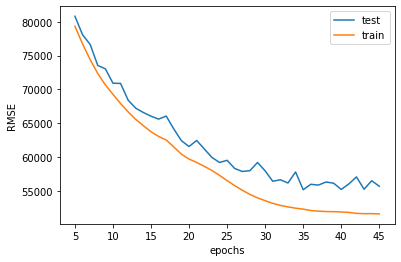

In [17]:
# plotting RMSE of of train and test data across epochs ignoring first 5 epochs
plt.figure(1)
plt.plot(range(5,len(history.history['val_root_mean_squared_error'])), history.history['val_root_mean_squared_error'][5:])
plt.plot(range(5,len(history.history['root_mean_squared_error'])), history.history['root_mean_squared_error'][5:])
plt.xlabel('epochs')
plt.legend(['test','train'])
plt.ylabel('RMSE')

## e) Using the model from the best epoch, report the test R 2 value and show the top 30 test samples with the largest errors. List down any trends you find in these samples and suggest ways to reduce these errors. (Tip: Add the prediction error as a column in the DataFrame and sort by it.)

In [24]:
# loading best model
best_model = tf.keras.models.load_model('./data/models/PartB_Q2/2d/best_model42',custom_objects ={'r2':r2})
test_prediction = best_model.predict(val_ds)

#append the predictions to the val dataframe
pd.set_option('display.float_format', lambda x: '%.3f' % x)
val_dataframe["test_prediction"] = test_prediction

#get the absolute error of test_prediction and the actual resale_price
val_dataframe["error"] = abs(val_dataframe["test_prediction"] - val_dataframe["resale_price"])

#sort and show top 30 largest error
val_dataframe.sort_values(by=['error'], inplace=True, ascending=False)

val_to_save = val_dataframe.head(30)
#save dataframe for largest errors to csv
val_to_save.to_csv("./data/top_30_errors.csv")

92/92 [==============================] - 1s 5ms/step


### Top 30 largest errors:

In [25]:
val_to_save

,month,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price,test_prediction,error
68105,2,0.353,2.413,0.034,0.121,37,89.917,107.000,13,1232000.000,261010.391,970989.609
83720,10,0.336,2.536,0.017,0.004,29,89.167,119.000,12,1200000.000,260651.938,939348.062
78257,8,0.353,2.413,0.034,0.121,37,89.333,107.000,14,1258000.000,384020.344,873979.656
67656,2,1.277,8.340,0.017,0.002,8,64.833,60.000,3,254000.000,1122437.500,868437.500
83126,10,0.321,2.419,0.034,0.121,37,89.250,105.000,10,1130000.000,290942.969,839057.031
70637,5,0.767,6.328,0.034,0.016,29,90.333,120.000,6,1070000.000,241079.141,828920.859
75090,6,0.971,15.151,0.017,0.000,9,61.917,74.000,0,250000.000,1069031.500,819031.500
83124,10,0.321,2.419,0.034,0.121,37,89.250,105.000,16,1248000.000,444071.844,803928.156
84648,10,0.515,4.108,0.017,0.024,29,90.500,114.000,12,1090000.000,289993.219,800006.781
66509,1,1.723,9.579,0.017,0.001,9,94.000,68.000,5,320000.000,1117669.500,797669.500


Best epoch is 42. we can get the respective val_r2

In [26]:
print( 'R2 for the model from the best epoch: {}'.format(history.history['val_r2'][41]))

R2 for the model from the best epoch: 0.8673686385154724


In [27]:
val_dataframe.head(30).flat_model_type.value_counts()

37    6
29    6
30    5
8     4
9     3
40    2
4     1
26    1
18    1
36    1
Name: flat_model_type, dtype: int64

it seems like most of flat model types are type 29 and 30.